## Orbital Dynamics Simulations and Numerical Integration Methods

In this section, we will explore the use of numerical integration methods to simulate the motion of a satellite in orbit, taking into account both perturbed and unperturbed dynamics. We will focus on two key methods: **Verlet Integration** and the **Runge-Kutta 4th order (RK4) method**, to understand how different time step sizes and algorithms impact the accuracy and convergence of our solutions.

### Key Concepts:
1. **Orbital Dynamics:**
   - The satellite's motion is governed by the laws of physics, specifically the gravitational forces between the satellite and the central body (e.g., Earth). These forces are modeled using Keplerian gravity (unperturbed) and more complex perturbations (such as gravitational anomalies or drag) in the perturbed system.

2. **Verlet Integration:**
   - The **Verlet integration method** is a straightforward numerical approach often used in orbital simulations. It updates positions and velocities at each time step by using previous values, with the key advantage of being simple and computationally efficient. However, it may not provide the highest accuracy for all systems, especially when using large time steps.

3. **Runge-Kutta 4th Order (RK4):**
   - The **RK4 method** is a more sophisticated integration technique that provides higher-order accuracy (4th order). It calculates intermediate values to achieve better approximations of the system's state at each time step, making it more precise than Verlet integration, especially for smaller step sizes.

4. **Perturbed vs. Unperturbed Systems:**
   - The **unperturbed system** considers only the primary gravitational force (Keplerian motion), while the **perturbed system** includes additional forces or anomalies. The comparison between these two systems will allow us to study the impact of perturbations on the satellite's trajectory.

5. **Error Analysis:**
   - To assess the accuracy of our numerical methods, we perform an **error analysis** by comparing the solutions from Verlet and RK4 integration methods with a reference solution obtained using a highly accurate solver. The error is calculated using the **root mean square (RMS)** of the position deviations.

6. **Convergence:**
   - We analyze the **convergence** of each method by varying the time step size and observing the relationship between step size and error. For the RK4 method, we expect a convergence rate proportional to \( O(h^4) \), where **h** is the step size.

### Objectives:
- **Visualize the satellite's trajectory** for both the perturbed and unperturbed systems over multiple orbital periods.
- **Compare the accuracy** of Verlet and RK4 methods by calculating and plotting the RMS error for different step sizes.
- **Analyze the convergence behavior** of the RK4 method and compare it to the theoretical error decay of \( O(h^4) \).

By performing these simulations and error analyses, we will gain insight into the performance of these integration methods for orbital dynamics problems and understand how numerical resolution impacts the accuracy of the simulated trajectories.


## Installing Required Package

This cell installs the `skyfield` package, which is used for astronomical calculations, such as computing satellite positions and orbital data. It is essential for running the main code and generating results related to satellite motion.


In [18]:
pip install skyfield

## Importing Required Libraries

This cell imports all the necessary libraries for the numerical method and plotting. The libraries include:


In [19]:
# Import necessary libraries for numerical computations, integration, and visualization.

import numpy as np  # For numerical operations like array handling
import math as m  # For mathematical functions (e.g., trigonometric)
import sympy as sp  # For symbolic mathematics and equation solving
from scipy.integrate import solve_ivp  # For solving ODEs
import matplotlib.pyplot as plt  # For plotting 2D graphs
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
import numpy.linalg as la  # For linear algebra operations
from skyfield.api import load  # For orbital mechanics and satellite data
from datetime import datetime  # For date and time handling
from pytz import timezone  # For timezone handling


# General equations
Starts with fundemental Keplerian dynamics: $$\ddot{\mathbf{r}} = -\frac{\mu}{r^3} \mathbf{r}$$
$\mu$ is constant for Earth  
r is position in cartesian coordinates   
$\ddot{\mathbf{r}}$ is acceleration in cartesian coordinates  

With perturbation: $$\ddot{\mathbf{r}} = -\frac{\mu}{r^3} \mathbf{r}+ p$$
where $$p = \frac{1}{m}(F)$$
F is all the forces affect the satellites. In our case, aerodynamic drag is negletic with 35,786 kilometers above the ground. J2 is considered due to Earth is not a perfect sphere. Solar Radiation Pressure is  considered. The third body of moon and sun is considered.  

So the formula became
$$\ddot{\mathbf{r}} = -\frac{\mu}{r^3} \mathbf{r} + \mathbf{p}_{J_2}+ \mathbf{p}_{SRP} + \mathbf{p}_{moon} + \mathbf{p}_{sun}$$

# Equations

### Formula for j2  
where R is radius of earth and r is the distance between satelites and origion(norm of x,y,z), j2 is constant
$$\mathbf{p}_{J_2} = \frac{3}{2} \frac{J_2 \mu R^2}{r^4}
\left[
\frac{x}{r} \left( 5 \left( \frac{z}{r} \right)^2 - 1 \right) \hat{\imath} +
\frac{y}{r} \left( 5 \left( \frac{z}{r} \right)^2 - 1 \right) \hat{\jmath} +
\frac{z}{r} \left( 5 \left( \frac{z}{r} \right)^2 - 3 \right) \hat{k}
\right]$$

### Formula for SRP  
$$\mathbf{p}_{SRP} = -\frac{S}{c} \frac{C_R A}{m} \hat{u}$$
S  = Solar irradiance (~1361 W/m² at Earth's distance).  
c  = Speed of light (~3.0 × 10^8 m/s)  
$C_R$ = Reflectivity coefficient (depends on surface material, typically 1-2)  
$C_R=1$ if surface absorbs all momentum from incident photons  
$C_R=2$ if all incident radiation is reflected (i.e. doubling force on the spacecraft)  
A  = Cross-sectional area exposed to sunlight (m²)  
m  = Satellite mass (kg)  
$\hat{u}$ = Unit vector in the direction of solar radiation (pointing from satellite toward the sun)

### Formula for moon attractions
$$\mathbf{p}_{moon} = {\mu_{\text{moon}}}(\frac{R_{\text{SM}}}{r_{\text{SM}}^3}-\frac{R_{\text{EM}}}{r_{\text{EM}}^3})$$
$R_{\text{SM}}$ is position vector from Satellite to Moon  
$r_{\text{SM}}$ distance from Satellite to Moon  
$R_{\text{EM}}$ is position vector from Earth to Moon  
$r_{\text{EM}}$ distance from Earth to Moon  

### Formula for sun attractions
$$\mathbf{p}_{sun} = {\mu_{\text{moon}}}(\frac{R_{\text{S ${\odot}$}}}{r_{\text{S${\odot}$}}^3}-\frac{R_{\text{E${\odot}$}}}{r_{\text{E${\odot}$}}^3})$$
$R_{\text{S ${\odot}$}}$ is position vector from Satellite to sun  
$r_{\text{S${\odot}$}}$ distance from Satellite to sun  
$R_{\text{E${\odot}$}}$ is position vector from Earth to sun  
$r_{\text{E${\odot}$}}$ distance from Earth to sun  

# Assumptions and definition

1. The coordinates system is cartesian system with the origion at the center of the earth and z pointing north pole.
2. Tilt of 23.5 degree for earth and inclination of 5.145 degree for the moon is considered
3. The simulating starts at 2025 April 7th 2pm Chicago time when the project is due.

## Defining Constants and Orbital Elements

This section defines the physical constants and initial conditions for the satellite’s orbit. It starts by specifying key constants used in the equations of motion, such as:

- `J2` for Earth's gravitational perturbation coefficient.
- `R_earth` for Earth's radius.
- `miu` for Earth's gravitational parameter.
- `S`, `c` for Solar irradiance and the speed of light, respectively.
- `mu_sun`, `mu_moon` for the gravitational parameters of the Sun and Moon.

Additionally, it defines the six orbital elements that describe the satellite’s initial orbit:

- `a` for semi-major axis (orbital radius).
- `e` for eccentricity (set to 0 for a circular orbit).
- `i` for inclination.
- `omu`, `omega`, and `M` for the argument of periapsis, longitude of ascending node, and mean anomaly, respectively.

Finally, it defines the satellite’s mass, cross-sectional area, and reflectivity coefficient for solar radiation pressure calculations.

The time of simulation is also defined (`simulating_times`), which will be used for numerical integration later in the code.
 https://orbitalmechanics.info/


In [20]:
# Defining constants used in the orbital dynamics and perturbation calculations

J2 = 1.08263e-3  # Earth's J2 coefficient (gravitational perturbation)
R_earth = 6378.137  # Radius of the Earth in km
miu = 398600.0  # Earth's gravitational parameter (km^3/s^2)
S = 1361.0  # Solar irradiance in W/m²
c = 3.0*(10**8)  # Speed of light in m/s
mu_sun = 1.327e11  # Gravitational parameter of the Sun (km^3/s^2)
mu_moon = 4902.8  # Gravitational parameter of the Moon (km^3/s^2)

# Orbital elements (semi-major axis, eccentricity, inclination, etc.)
a = 42164  # Semi-major axis in km
e = 0  # Eccentricity (0 for a circular orbit)
i = 35/180*np.pi  # Inclination in radians
omu = 100/180*np.pi  # Argument of periapsis in radians
omega = 30/180*np.pi  # Longitude of ascending node in radians
M = 0/180*np.pi  # Mean anomaly in radians (0 for simplicity)

# Define simulation inputs and satellite properties
simulating_times = 2  # Duration of the simulation in days
mass = 500.0  # Satellite mass in kilograms
A = 10.0  # Satellite's cross-sectional area exposed to sunlight in square meters
C_R = 1.2  # Reflectivity coefficient, a value between 1 and 2 depending on surface material properties


### Transfer Orbital Elements to Cartesian Coordinates

In this section, the orbital elements are transferred into Cartesian coordinates. The initial position `r0` and velocity `v0` are computed using Keplerian orbital elements.

The code follows the iterative method for solving the Kepler's equation for the eccentric anomaly `E0`, which is then used to calculate the true anomaly `f` and the satellite's position in 3D space.

The relevant orbital elements include:
- Semi-major axis `a`
- Eccentricity `e`
- Orbital inclination `i`
- Argument of periapsis `omega`
- Longitude of ascending node `omu`
- Mean anomaly `M`

The final outcome of this step is the satellite's position `r0` and velocity `v0` in Cartesian coordinates, which are needed for further analysis and simulations.



In [21]:
# Import necessary math functions
import math as m

# Set initial value for Eccentric Anomaly (E0) equal to the Mean Anomaly (M)
E0 = M
g = 1  # Initialize g (difference between calculated and predicted values)
itr = 0  # Initialize iteration counter
tol = 1e-10  # Set tolerance for convergence

# Iterative solution for Kepler's equation to solve for Eccentric Anomaly (E)
while(abs(g) > tol):
    g = E0 - e * m.sin(E0) - M  # Kepler's equation
    dgde = 1 - e * m.cos(E0)  # Derivative of Kepler's equation with respect to E
    E1 = E0 - g/dgde  # Update the eccentric anomaly using Newton-Raphson method
    E0 = E1  # Set new Eccentric Anomaly
    itr += 1  # Increment iteration counter

# Calculate the true anomaly 'f' from the eccentric anomaly 'E'
f = 2 * m.atan2((1 + e)**0.5 * m.tan(E0 / 2), (1 - e)**0.5)
theta = omega+f

# Calculate the orbital radius 'rmag1' based on the true anomaly 'f'
rmag1 = a * (1 - e**2) / (1 + e * m.cos(f))

# Calculate specific angular momentum 'hmag'
hmag = (miu * a * (1 - e**2))**0.5


### Calculate Position Components in Cartesian Coordinates

In this section, we calculate the position components of the satellite in Cartesian coordinates based on its orbital geometry. Using the true anomaly `f` and orbital parameters, we determine the x, y, and z components of the satellite's position.

The position vector `r0` is calculated using the following components:
- `r1` (x-component)
- `r2` (y-component)
- `r3` (z-component)

These components are derived from the orbital inclination `i`, longitude of ascending node `omu`, and true anomaly `theta`.

The final position vector `r0` represents the satellite's location in 3D space at the current point in its orbit.


In [22]:
# Calculate the x-component of the position (r1)
r1 = m.cos(theta) * m.cos(omu) - m.cos(i) * m.sin(omu) * m.sin(theta)

# Calculate the y-component of the position (r2)
r2 = m.cos(theta) * m.sin(omu) + m.cos(i) * m.cos(omu) * m.sin(theta)

# Calculate the z-component of the position (r3)
r3 = m.sin(i) * m.sin(theta)

# Construct the position vector r0 in Cartesian coordinates using the magnitude and components
r0 = rmag1 * np.array([r1, r2, r3])  # Position vector in 3D space

# Output the position vector r0
r0


array([-23347.78268946,  32961.55529776,  12092.13843115])

### Calculate Velocity Components in Cartesian Coordinates

In this section, we compute the velocity components of the satellite in Cartesian coordinates. The satellite's velocity is derived using its orbital elements, such as the true anomaly `theta`, the argument of perigee `omega`, and the inclination `i`.

We use the vis-viva equation to compute the velocity components:
- `v1` (x-component of the velocity)
- `v2` (y-component of the velocity)
- `v3` (z-component of the velocity)

The velocity vector `v0` is then constructed using these components, representing the satellite's velocity in 3D space at the current position.


In [23]:
# Calculate the x-component of the velocity (v1)
v1 = -miu / hmag * (m.cos(omu) * (m.sin(theta) + e * m.sin(omega)) +
                   m.sin(omu) * (m.cos(theta) + e * m.cos(omega)) * m.cos(i))

# Calculate the y-component of the velocity (v2)
v2 = -miu / hmag * (m.sin(omu) * (m.sin(theta) + e * m.sin(omega)) -
                   m.cos(omu) * (m.cos(theta) + e * m.cos(omega)) * m.cos(i))

# Calculate the z-component of the velocity (v3)
v3 = miu / hmag * ((m.cos(theta) + e * m.cos(omega)) * m.sin(i))

# Construct the velocity vector v0 in Cartesian coordinates using the components
v0 = np.array([v1, v2, v3])  # Velocity vector in 3D space

# Output the velocity vector v0
v0


array([-1.88109489, -1.8927359 ,  1.52728356])

### Load Planetary Data and Initialize Time

In this section, we load planetary data from the `de421.bsp` file, which contains the positions of celestial bodies like the Earth, Sun, and Moon. We then define the initial time for the simulation and convert it to UTC time for consistency. The time is used in further calculations of planetary positions and velocities.

The `timescale` module is also used to create a time object for precise time handling in the simulation.


In [24]:
# Load planetary data from the DE421 planetary ephemeris file
planets = load('de421.bsp')

# Access specific planets (Earth, Sun, and Moon) from the loaded ephemeris data
earth = planets['earth']
sun = planets['sun']
moon = planets['moon']

# Define the initial time for the simulation (April 7, 2025 at 14:00:00)
initial_time = datetime(2025, 4, 7, 14, 0, 0)

# Set the timezone to America/Chicago and localize the time to Chicago timezone
tz = "America/Chicago"
chicago_time = timezone(tz).localize(initial_time)

# Convert the local time (Chicago time) to UTC
utc_time = chicago_time.astimezone(timezone('UTC'))

# Create a timescale object for time handling in the simulation
ts = load.timescale()

# Initialize the time object (int_t) in UTC format using the current year, month, day, hour, minute, and second
int_t = ts.utc(utc_time.year, utc_time.month, utc_time.day, utc_time.hour, utc_time.minute, utc_time.second)


### Define the System of Equations for Orbital Dynamics

This function `system(t, y)` defines the system of differential equations governing the satellite's orbital motion. It includes the following components:

1. **Orbital Elements**: The position (`r`) and velocity (`v`) vectors are extracted from the state vector `y`.
2. **Celestial Body Positions**: The positions of the Sun and Moon are calculated at the given time `t`.
3. **Gravitational Forces**: The gravitational attractions of the Sun and Moon on the satellite are calculated.
4. **Perturbations**: The effect of the Earth's oblateness (`J2`) and the Solar Radiation Pressure (SRP) are included.
5. **Equations of Motion**: The system returns the derivatives of the orbital elements, describing how the satellite’s position and velocity change over time.


In [25]:
def system(t, y):
    # Unpack state vector (position and velocity)
    y1, y2, y3, y4, y5, y6 = y
    r = la.norm(y[0:3])  # Position magnitude (distance from the origin)
    v = la.norm(y[3:])   # Velocity magnitude

    # Find Sun and Moon positions at the current time
    current_time = int_t + (t)/(24*3600)  # Time in days
    sun_position = (earth.at(current_time).observe(sun)).apparent()  # Sun's position
    moon_position = (earth.at(current_time).observe(moon)).apparent()  # Moon's position

    # Extract the x, y, z coordinates for the Sun and Moon
    sun_x, sun_y, sun_z = sun_position.xyz.km
    moon_x, moon_y, moon_z = moon_position.xyz.km

    # Convert to numpy arrays for easier manipulation
    sun_loc = np.array([sun_x, sun_y, sun_z])
    moon_loc = np.array([moon_x, moon_y, moon_z])

    # Calculate satellite-to-Sun and satellite-to-Moon vectors
    satellite_sun = sun_loc - r  # Vector pointing from satellite to Sun
    satellite_moon = moon_loc - r  # Vector pointing from satellite to Moon

    # J2 perturbation (Earth's oblateness effect)
    factor1 = 3/2 * J2 * miu * R_earth**2 / (r**4)  # Factor involving Earth's oblateness
    j2_x = factor1 * y1/r * (5 * (y3**2 / r**2)-1)  # J2 effect in the x-direction
    j2_y = factor1 * y2/r * (5 * (y3**2 / r**2)-1)  # J2 effect in the y-direction
    j2_z = factor1 * y3/r * (5 * (y3**2 / r**2)-3)  # J2 effect in the z-direction

    # Solar Radiation Pressure (SRP) effect
    factor2 = -(S/c)/(C_R*A)/mass  # SRP factor
    SRP_x = factor2 * satellite_sun[0] / la.norm(satellite_sun)  # SRP effect in the x-direction
    SRP_y = factor2 * satellite_sun[1] / la.norm(satellite_sun)  # SRP effect in the y-direction
    SRP_z = factor2 * satellite_sun[2] / la.norm(satellite_sun)  # SRP effect in the z-direction

    # Moon's gravitational attraction on the satellite
    moon_x = mu_moon*(satellite_moon[0]/(la.norm(satellite_moon))**3-moon_loc[0]/(la.norm(moon_loc))**3)
    moon_y = mu_moon*(satellite_moon[1]/(la.norm(satellite_moon))**3-moon_loc[1]/(la.norm(moon_loc))**3)
    moon_z = mu_moon*(satellite_moon[2]/(la.norm(satellite_moon))**3-moon_loc[2]/(la.norm(moon_loc))**3)

    # Sun's gravitational attraction on the satellite
    sun_x = mu_sun*(satellite_sun[0]/(la.norm(satellite_sun))**3-sun_loc[0]/(la.norm(sun_loc))**3)
    sun_y = mu_sun*(satellite_sun[1]/(la.norm(satellite_sun))**3-sun_loc[1]/(la.norm(sun_loc))**3)
    sun_z = mu_sun*(satellite_sun[2]/(la.norm(satellite_sun))**3-sun_loc[2]/(la.norm(sun_loc))**3)

    # Differential equations for the orbital state
    dy1_dt = y4  # Rate of change of position in the x-direction
    dy2_dt = y5  # Rate of change of position in the y-direction
    dy3_dt = y6  # Rate of change of position in the z-direction
    dy4_dt = -miu*y1/(r**3) + j2_x + SRP_x + moon_x + sun_x  # Rate of change of velocity in the x-direction
    dy5_dt = -miu*y2/(r**3) + j2_y + SRP_y + moon_y + sun_y  # Rate of change of velocity in the y-direction
    dy6_dt = -miu*y3/(r**3) + j2_z + SRP_z + moon_z + sun_z  # Rate of change of velocity in the z-direction

    # Return the derivatives as a list
    return [dy1_dt, dy2_dt, dy3_dt, dy4_dt, dy5_dt, dy6_dt]


### 3D Orbital Trajectory using Verlet Integration

This script uses **Verlet Integration** to simulate and visualize the orbital trajectory of a satellite under the influence of various forces (such as gravitational attractions from celestial bodies).

- **Verlet Integration**: A numerical method used to integrate the equations of motion. It is widely used in orbital mechanics because it conserves energy better than some other methods like Euler's method.

#### Components:
1. **Verlet Integration Function**: `verlet_integration(f, t_span, t_eval, y0)` takes the system of differential equations `f`, the time span `t_span`, the time evaluation points `t_eval`, and the initial conditions `y0`. It returns the times and the positions/velocities of the satellite.
2. **True Solution**: The true solution is calculated using `solve_ivp`, which solves the system of ODEs using more accurate built-in solvers for comparison.
3. **3D Trajectory Plot**: The plot visualizes the satellite's trajectory over time in 3D, with the start and end points highlighted.

#### Outputs:
- **3D Plot**: A 3D trajectory plot of the satellite's orbit.
- **Time Step**: The time step used for the simulation is printed at the end, showing the difference between two consecutive time evaluations.


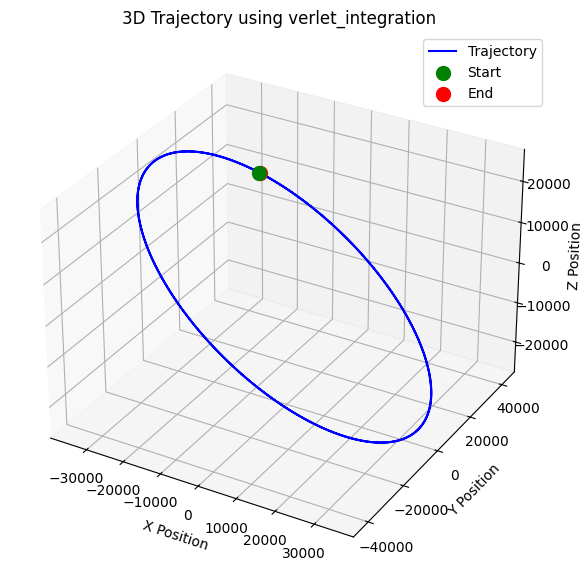

172.49973633938987


In [26]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

# Verlet integration method
def verlet_integration(f, t_span, t_eval, y0):
    # Define the time step
    h = t_eval[1] - t_eval[0]
    num_steps = len(t_eval)  # Number of time steps
    Y = np.zeros((num_steps, len(y0)))  # Initialize the solution array
    Y[0] = y0  # Set initial conditions

    # Initial velocity step using Euler method
    v0 = y0[3:]  # Initial velocity (last 3 elements of initial state)
    r0 = y0[:3]  # Initial position (first 3 elements of initial state)
    a0 = np.array(f(0, y0))[3:]  # Initial acceleration (derived from system)
    Y[1, :3] = r0 + h * v0 + 0.5 * h**2 * a0  # Position update using Euler method
    Y[1, 3:] = v0 + h * a0  # Velocity update using Euler method

    # Loop to perform Verlet integration for each time step
    for i in range(1, num_steps - 1):
        t = t_eval[i]  # Current time
        a_prev = np.array(f(t - h, Y[i - 1]))[3:]  # Previous acceleration
        a_current = np.array(f(t, Y[i]))[3:]  # Current acceleration
        Y[i + 1, :3] = 2 * Y[i, :3] - Y[i - 1, :3] + h**2 * a_current  # Update position
        Y[i + 1, 3:] = (Y[i + 1, :3] - Y[i, :3]) / h  # Update velocity

    return t_eval, Y  # Return time steps and the solution

# Initial conditions for the simulation
initial_conditions = np.hstack([r0, v0])  # Initial position and velocity
orbital_period = 2 * np.pi * np.sqrt(a**3 / miu)  # Orbital period from Kepler's third law
t_span = (0, orbital_period * simulating_times)  # Time span of the simulation
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points for evaluation

# Run Verlet integration to get the trajectory
t_values, results = verlet_integration(system, t_span, t_eval, initial_conditions)

# Extract position values (x, y, z)
x_vals, y_vals, z_vals = results[:, 0], results[:, 1], results[:, 2]

# True solution using solve_ivp (for comparison)
true_solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, rtol=1e-10, atol=1e-13)

# 3D plot of the trajectory
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D plot
ax.plot(x_vals, y_vals, z_vals, label="Trajectory", color='blue')  # Plot trajectory
ax.scatter(x_vals[0], y_vals[0], z_vals[0], color='green', label="Start", s=100)  # Start point
ax.scatter(x_vals[-1], y_vals[-1], z_vals[-1], color='red', label="End", s=100)  # End point

# Labels and title for the plot
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_zlabel("Z Position")
ax.set_title("3D Trajectory using verlet_integration")
ax.legend()  # Show legend
plt.show()  # Display the plot

# Print the time step size used in the simulation
print(t_eval[1] - t_eval[0])


### Stability Region for Verlet Integration

This plot represents the stability of the **Verlet integration** method when applied to a harmonic oscillator. The stability condition for Verlet integration is given by the inequality \( h \omega \leq 2 \), where \( h \) is the step size, and \( \omega \) is the angular frequency of the oscillator.

#### Key Features:
1. **Stable Region (Green)**: The green region represents the values of \( h \omega \) that satisfy the stability condition \( h \omega \leq 2 \). In this region, the Verlet integration method produces accurate results.
2. **Unstable Region (Red)**: The red region represents the values of \( h \omega \) where \( h \omega > 2 \), which leads to instability in the Verlet integration method.
3. **Stability Boundary (Dashed Line)**: The dashed black line at \( h \omega = 2 \) marks the boundary between the stable and unstable regions.

#### X-Axis:
- \( h \omega \): The product of the step size and angular frequency.

#### Y-Axis:
- Stability: The stability of the system (1 for stable, 0 for unstable).

This plot helps in understanding where the Verlet method remains stable and where it may fail when solving the equations of motion for a harmonic oscillator.


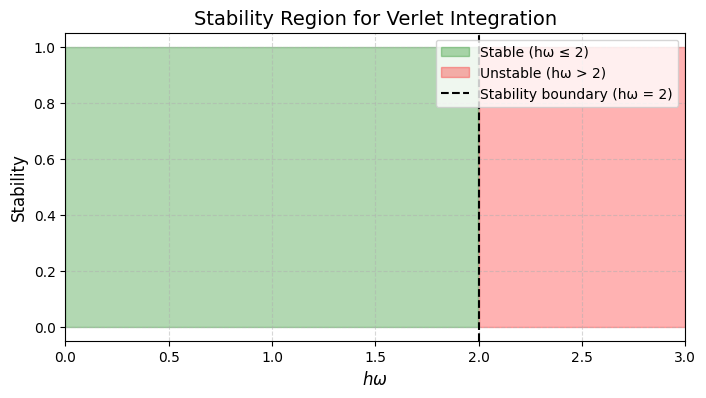

In [27]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Define the range of h*omega values (h = step size, omega = frequency of the harmonic oscillator)
h_omega = np.linspace(0, 3, 500)  # Values ranging from 0 to 3 to cover stable and unstable regions

# Stability condition for Verlet integration: h*omega <= 2
stable = (h_omega <= 2)  # Boolean array: True for stable, False for unstable

# Create the plot
plt.figure(figsize=(8, 4))

# Fill the stable region (green) and unstable region (red)
plt.fill_between(h_omega, 0, 1, where=stable, color='green', alpha=0.3, label='Stable (hω ≤ 2)')
plt.fill_between(h_omega, 0, 1, where=~stable, color='red', alpha=0.3, label='Unstable (hω > 2)')

# Add a vertical line at the stability boundary (h*omega = 2)
plt.axvline(x=2, color='black', linestyle='--', label='Stability boundary (hω = 2)')

# Label the axes and title
plt.xlabel(r'$h \omega$', fontsize=12)  # X-axis label with LaTeX formatting
plt.ylabel('Stability', fontsize=12)  # Y-axis label
plt.title('Stability Region for Verlet Integration', fontsize=14)  # Title of the plot

# Add legend and grid
plt.legend(loc='upper right')  # Legend in the upper right corner
plt.grid(True, linestyle='--', alpha=0.5)  # Grid for better visibility

# Set x-axis limits to focus on the relevant region (0 to 3)
plt.xlim(0, 3)

# Show the plot
plt.show()


## Explanation of the Code for Error Analysis of Verlet Integration

This Python code compares the results obtained from the Verlet Integration method with the true solution of a system of differential equations. It computes several error metrics to evaluate the accuracy of the Verlet method's predictions over time. The key metrics include:

### Key Steps:

1. **Extracting the True Solution:**
   - The code retrieves the true solution for the system (i.e., the positions along the X, Y, and Z axes) from the `solve_ivp` result object. The true solution's position values are stored in `true_x`, `true_y`, and `true_z`.

2. **Computing Absolute Errors:**
   - The absolute errors between the Verlet solution and the true solution are calculated for each component (X, Y, and Z). These are computed using the `np.abs()` function, which takes the absolute difference between the calculated values (`x_vals`, `y_vals`, `z_vals`) and the true values (`true_x`, `true_y`, `true_z`).

3. **Computing Relative Errors:**
   - The relative errors are calculated by dividing the absolute error by the true value for each component. A small constant (`1e-16`) is added to the true value to avoid division by zero, ensuring stability in the error calculation.

4. **Root Mean Square Error (RMSE):**
   - The **RMSE** for each component is computed using the formula for the root of the mean of the squared errors. This provides a measure of the average magnitude of the error for each component.

5. **Maximum Absolute Error:**
   - The maximum absolute error for each component is calculated using `np.max()`, which gives the largest error at any point in time.

6. **Printing the Results:**
   - The RMSE and maximum absolute errors for each of the X, Y, and Z components are printed to the console for inspection.

7. **Plotting the Errors:**
   - Two separate plots are generated:
     - **Absolute Error Plot:** Displays the absolute error for each component over time, with a logarithmic scale on the Y-axis to visualize large variations in error.
     - **Relative Error Plot:** Displays the relative error for each component over time, also using a logarithmic scale for better visualization.

### Visual Output:
- The code generates two plots:
  1. **Absolute Error vs Time:** Shows how the error in each component (X, Y, Z) changes with time.
  2. **Relative Error vs Time:** Shows how the relative error in each component evolves over time.


RMSE (X): 1.0357e+01
RMSE (Y): 1.1283e+01
RMSE (Z): 7.1091e+00
Max Abs Error (X): 2.3567e+01
Max Abs Error (Y): 2.5513e+01
Max Abs Error (Z): 1.6331e+01


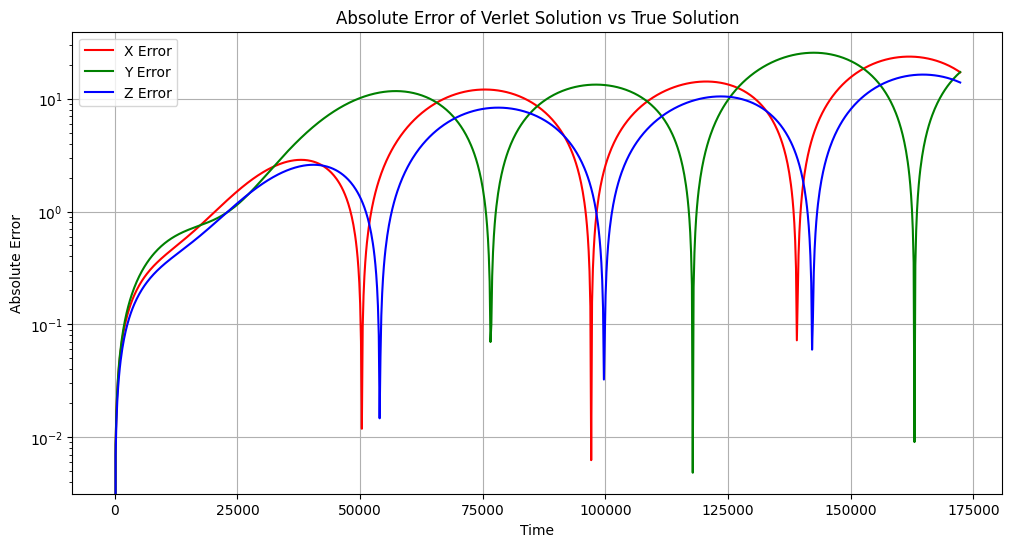

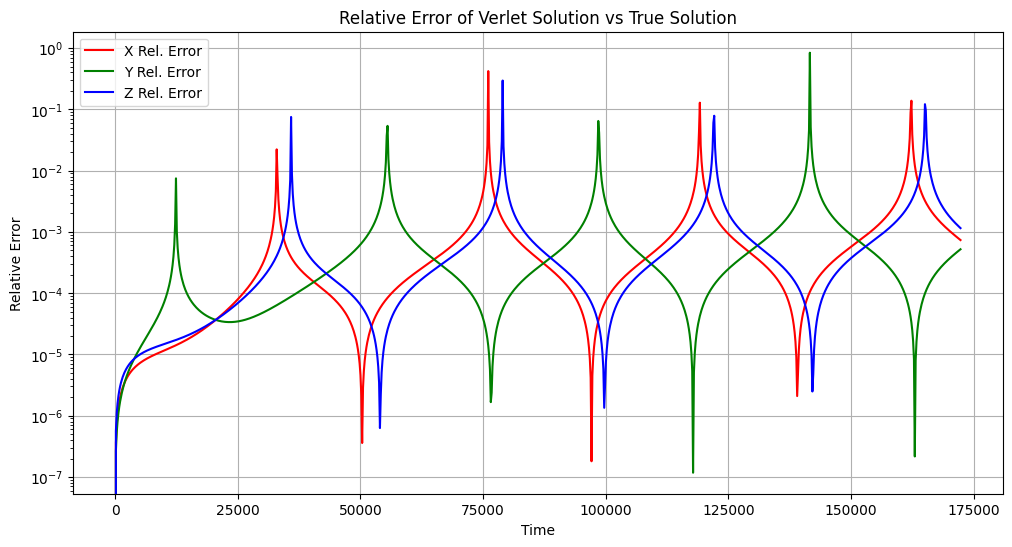

In [28]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

# Extract the true solution components (X, Y, Z) from the solve_ivp result
true_x = true_solution.y[0]  # True X position
true_y = true_solution.y[1]  # True Y position
true_z = true_solution.y[2]  # True Z position

# Compute the absolute errors between the Verlet solution and the true solution
abs_error_x = np.abs(x_vals - true_x)  # Absolute error in X
abs_error_y = np.abs(y_vals - true_y)  # Absolute error in Y
abs_error_z = np.abs(z_vals - true_z)  # Absolute error in Z

# Compute the relative errors (avoiding division by zero using a small constant)
rel_error_x = np.abs((x_vals - true_x) / (true_x + 1e-16))  # Relative error in X
rel_error_y = np.abs((y_vals - true_y) / (true_y + 1e-16))  # Relative error in Y
rel_error_z = np.abs((z_vals - true_z) / (true_z + 1e-16))  # Relative error in Z

# Calculate the RMSE for each component
rmse_x = np.sqrt(np.mean(abs_error_x**2))  # RMSE for X
rmse_y = np.sqrt(np.mean(abs_error_y**2))  # RMSE for Y
rmse_z = np.sqrt(np.mean(abs_error_z**2))  # RMSE for Z

# Calculate the maximum absolute errors for each component
max_abs_error_x = np.max(abs_error_x)  # Max absolute error in X
max_abs_error_y = np.max(abs_error_y)  # Max absolute error in Y
max_abs_error_z = np.max(abs_error_z)  # Max absolute error in Z

# Print the computed RMSE and maximum absolute errors
print(f"RMSE (X): {rmse_x:.4e}")
print(f"RMSE (Y): {rmse_y:.4e}")
print(f"RMSE (Z): {rmse_z:.4e}")
print(f"Max Abs Error (X): {max_abs_error_x:.4e}")
print(f"Max Abs Error (Y): {max_abs_error_y:.4e}")
print(f"Max Abs Error (Z): {max_abs_error_z:.4e}")

# Plot the absolute errors over time for each component (X, Y, Z)
plt.figure(figsize=(12, 6))
plt.plot(t_values, abs_error_x, label="X Error", color='r')  # Plot X error
plt.plot(t_values, abs_error_y, label="Y Error", color='g')  # Plot Y error
plt.plot(t_values, abs_error_z, label="Z Error", color='b')  # Plot Z error
plt.xlabel("Time")  # X-axis label (Time)
plt.ylabel("Absolute Error")  # Y-axis label (Absolute Error)
plt.title("Absolute Error of Verlet Solution vs True Solution")  # Plot title
plt.yscale("log")  # Set Y-axis to log scale to visualize wide error variations
plt.legend()  # Show legend
plt.grid()  # Show grid
plt.show()  # Display the plot

# Plot the relative errors over time for each component (X, Y, Z)
plt.figure(figsize=(12, 6))
plt.plot(t_values, rel_error_x, label="X Rel. Error", color='r')  # Plot X relative error
plt.plot(t_values, rel_error_y, label="Y Rel. Error", color='g')  # Plot Y relative error
plt.plot(t_values, rel_error_z, label="Z Rel. Error", color='b')  # Plot Z relative error
plt.xlabel("Time")  # X-axis label (Time)
plt.ylabel("Relative Error")  # Y-axis label (Relative Error)
plt.title("Relative Error of Verlet Solution vs True Solution")  # Plot title
plt.yscale("log")  # Set Y-axis to log scale to visualize wide error variations
plt.legend()  # Show legend
plt.grid()  # Show grid
plt.show()  # Display the plot


## Explanation of the Code for Verlet Integration and Error Convergence

This code applies the **Verlet integration** method to a 6-DOF system and evaluates the method's convergence by testing different step sizes. The integration is compared against a reference solution obtained from a high-accuracy **Runge-Kutta 4th order method (RK45)**. The key elements of the code are explained below:

### Key Steps:

1. **Verlet Integration Function:**
   - The `verlet_integration` function integrates the system of equations using the **Verlet integration** method.
   - The Verlet algorithm updates positions based on the current and previous positions and accelerations, offering better accuracy than simple Euler integration.
   - The function takes:
     - `f`: The system of equations that defines the dynamics of the problem (forces and accelerations).
     - `t_span`: The start and end times for the simulation.
     - `t_eval`: The time values where the solution is evaluated.
     - `y0`: The initial conditions (positions and velocities).

2. **Initial Step with Euler:**
   - The algorithm starts with an Euler step to initialize the first two positions and velocities since Verlet needs the previous position and velocity for its update.
   - The velocity and position at `t[1]` are computed using Euler's method and acceleration `a0`.

3. **Subsequent Steps Using Verlet:**
   - After initializing the first two steps, the positions and velocities are updated using the **Verlet method** for the remaining time steps. The position update equation incorporates the previous position and velocity along with the current acceleration.
   - The velocity is updated using finite differences between positions.

4. **Step Size Testing:**
   - The code tests several step sizes (`step_sizes = [100, 50, 20, 10, 5]`), which represent the time intervals used for the simulation.
   - For each step size, the code integrates the system using the Verlet method and calculates the error between the Verlet solution and the reference solution.

5. **Reference Solution (RK45):**
   - The reference solution is computed using **`solve_ivp`** with the high-accuracy **RK45 method** to obtain a highly accurate trajectory.
   - The RMS (Root Mean Square) error between the positions obtained from the Verlet integration and the reference solution is calculated.

6. **Error Computation and Plotting:**
   - The RMS position error is computed for each step size and stored in the `errors` list.
   - A **log-log plot** is created to show the relationship between the step size and the error. The expected **$O(h^2)$** convergence is plotted for reference, indicating that the error should decrease quadratically with smaller step sizes.

### Visual Output:
- The code generates a log-log plot showing the **step size vs RMS position error**. The plot helps visualize the error convergence and verify the second-order convergence of the Verlet method.


Verlet Method RMS error convergence

Step size = 100 s → Error = 5.67e+00
Step size = 50 s → Error = 1.42e+00
Step size = 20 s → Error = 2.27e-01
Step size = 10 s → Error = 5.67e-02
Step size = 5 s → Error = 1.42e-02


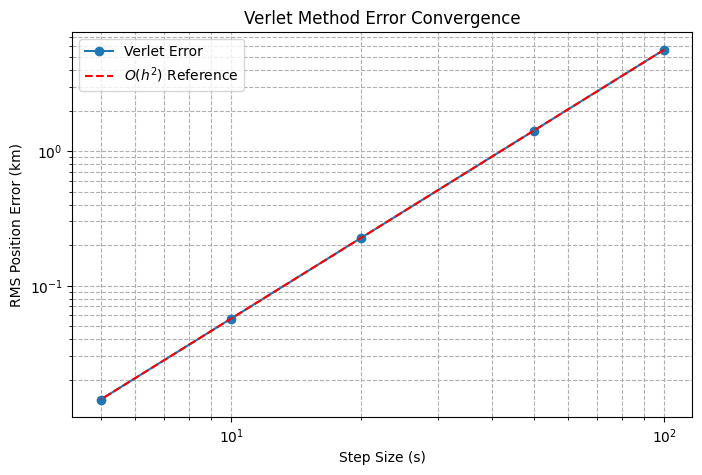

In [29]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the Verlet integrator (adapted for your 6-DOF system)
def verlet_integration(f, t_span, t_eval, y0):
    h = t_eval[1] - t_eval[0]  # Step size
    num_steps = len(t_eval)  # Total number of steps
    Y = np.zeros((num_steps, len(y0)))  # Array to store solution at each step
    Y[0] = y0  # Set initial conditions

    # Initial step using Euler (since Verlet needs previous position)
    a0 = np.array(f(t_span[0], y0))[3:]  # Extract acceleration from the system
    Y[1, :3] = y0[:3] + h * y0[3:] + 0.5 * h**2 * a0  # Update position
    Y[1, 3:] = y0[3:] + h * a0  # Update velocity

    # Subsequent steps using Verlet
    for i in range(1, num_steps - 1):
        t = t_eval[i]  # Current time
        a_current = np.array(f(t, Y[i]))[3:]  # Current acceleration
        Y[i + 1, :3] = 2 * Y[i, :3] - Y[i - 1, :3] + h**2 * a_current  # Position update
        Y[i + 1, 3:] = (Y[i + 1, :3] - Y[i, :3]) / h  # Velocity update (finite difference)

    return t_eval, Y

# Test parameters: different step sizes to test the convergence
step_sizes = [100, 50, 20, 10, 5]  # Step sizes to test (seconds)
t_span = (0, orbital_period * simulating_times)  # Simulation time range
errors = []  # List to store errors for each step size

# Loop over each step size
for h in step_sizes:
    # Generate time grid for current step size
    t_eval = np.arange(t_span[0], t_span[1], h)

    # Run Verlet integration
    t_verlet, Y_verlet = verlet_integration(system, t_span, t_eval, initial_conditions)

    # Get reference solution using high-accuracy RK45 method
    ref_sol = solve_ivp(
        system, t_span, initial_conditions,
        t_eval=t_eval,
        rtol=1e-12,  # High relative tolerance for accuracy
        atol=1e-12   # High absolute tolerance for accuracy
    ).y.T

    # Compute RMS error between Verlet and reference solution (position)
    error = np.sqrt(np.mean(np.sum((Y_verlet[:, :3] - ref_sol[:, :3])**2, axis=1)))
    errors.append(error)  # Append error for the current step size
    print(f"Step size = {h} s → Error = {error:.2e}")  # Print the error

# Plot convergence: Step size vs RMS error
plt.figure(figsize=(8, 5))
plt.loglog(step_sizes, errors, 'o-', label='Verlet Error')  # Plot the Verlet method error
plt.xlabel('Step Size (s)')  # X-axis label
plt.ylabel('RMS Position Error (km)')  # Y-axis label
plt.title('Verlet Method Error Convergence')  # Title of the plot
plt.grid(True, which="both", ls="--")  # Show grid on both axes

# Add theoretical slope for reference (Verlet method has O(h^2) convergence)
theoretical_slope = [errors[0] * (h / step_sizes[0])**2 for h in step_sizes]
plt.loglog(step_sizes, theoretical_slope, 'r--', label='$O(h^2)$ Reference')  # Plot the expected convergence
plt.legend()  # Display legend
plt.show()  # Display the plot


## Explanation of the Code for Verlet Integration and L2 Error Convergence

This code uses the **Verlet integration** method to simulate a 6-DOF system and evaluates its accuracy by computing the **L2 error** between the Verlet solution and a reference solution obtained from a high-accuracy **Runge-Kutta 4th order method (RK45)**. The L2 error is used to measure the relative difference in the position between the Verlet and reference solutions. Below is an explanation of the key components:

### Key Steps:

1. **Verlet Integration Function:**
   - The `verlet_integration` function implements the **Verlet integration** method for solving the system of equations. It calculates positions and velocities for each time step.
   - The function takes the following parameters:
     - `f`: The system of differential equations representing the forces and accelerations.
     - `t_span`: The start and end times for the simulation.
     - `t_eval`: The time values at which the solution is evaluated.
     - `y0`: The initial conditions (positions and velocities).

2. **Initial Step Using Euler:**
   - The first step uses the **Euler method** for the initial time step, as the Verlet method requires the previous position and velocity. The position is updated with the current velocity and acceleration, and the velocity is updated with the acceleration.

3. **Subsequent Steps Using Verlet:**
   - After the first step, the **Verlet method** is used to update the position and velocity at each subsequent time step.
   - The position is updated using the previous position and velocity, and the velocity is updated using finite differences.

4. **Step Size Testing:**
   - The code tests several step sizes (`step_sizes = [100, 50, 20, 10, 5]`) to evaluate the convergence of the method. The smaller the step size, the more accurate the solution should be.

5. **Reference Solution (RK45):**
   - The reference solution is computed using the **`solve_ivp`** function with the high-accuracy **RK45 method**. This provides a more accurate solution for comparison.

6. **L2 Error Computation:**
   - The **L2 error** is computed to assess the accuracy of the Verlet method. The error is calculated as the relative L2 norm of the difference between the Verlet and reference solutions. The formula used is:

$$
\text{L2 Error} = \frac{\lVert Y_{\text{Verlet}} - Y_{\text{ref}} \rVert_2}{\lVert Y_{\text{ref}} \rVert_2}
$$

where $$ Y_{\text{Verlet}} $$ and $$ Y_{\text{ref}} $$ are the positions of the Verlet and reference solutions, respectively.
Notes:

7. **Plotting Error Convergence:**
   - A **log-log plot** is generated to show the relationship between the step size and the L2 error. The expected **$O(h^2)$** convergence is also plotted for reference, which indicates that the error should decrease quadratically with decreasing step size.

### Visual Output:
- The plot shows the **step size vs L2 error** for the Verlet integration method and compares it with the theoretical error convergence. This allows us to evaluate the method's accuracy and verify its second-order convergence behavior.



Step size = 100 s → L2 Error = 1.14e-04
Step size = 50 s → L2 Error = 2.86e-05
Step size = 20 s → L2 Error = 4.58e-06
Step size = 10 s → L2 Error = 1.15e-06
Step size = 5 s → L2 Error = 2.86e-07


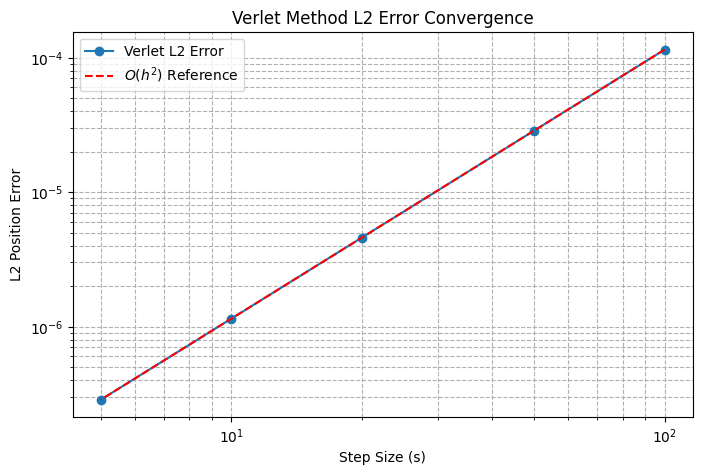

In [30]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the Verlet integrator (adapted for your 6-DOF system)
def verlet_integration(f, t_span, t_eval, y0):
    h = t_eval[1] - t_eval[0]  # Step size
    num_steps = len(t_eval)  # Total number of steps
    Y = np.zeros((num_steps, len(y0)))  # Array to store solution at each step
    Y[0] = y0  # Set initial conditions

    # Initial step using Euler (since Verlet needs previous position)
    a0 = np.array(f(t_span[0], y0))[3:]  # Extract acceleration from the system
    Y[1, :3] = y0[:3] + h * y0[3:] + 0.5 * h**2 * a0  # Update position
    Y[1, 3:] = y0[3:] + h * a0  # Update velocity

    # Subsequent steps using Verlet
    for i in range(1, num_steps - 1):
        t = t_eval[i]  # Current time
        a_current = np.array(f(t, Y[i]))[3:]  # Current acceleration
        Y[i + 1, :3] = 2 * Y[i, :3] - Y[i - 1, :3] + h**2 * a_current  # Position update
        Y[i + 1, 3:] = (Y[i + 1, :3] - Y[i, :3]) / h  # Velocity update (finite difference)

    return t_eval, Y

# Test parameters: different step sizes to test the convergence
step_sizes = [100, 50, 20, 10, 5]  # Step sizes to test (seconds)
t_span = (0, orbital_period * simulating_times)  # Simulation time range
errors = []  # List to store L2 errors for each step size

# Loop over each step size
for h in step_sizes:
    # Generate time grid for current step size
    t_eval = np.arange(t_span[0], t_span[1], h)

    # Run Verlet integration
    t_verlet, Y_verlet = verlet_integration(system, t_span, t_eval, initial_conditions)

    # Get reference solution using high-accuracy RK45 method
    ref_sol = solve_ivp(
        system, t_span, initial_conditions,
        t_eval=t_eval,
        rtol=1e-12,  # High relative tolerance for accuracy
        atol=1e-12   # High absolute tolerance for accuracy
    ).y.T

    # Compute the L2 error (relative error)
    # Difference between Verlet and reference solution
    diff = Y_verlet[:, :3] - ref_sol[:, :3]

    # L2 norm of the difference
    norm_diff = np.linalg.norm(diff, axis=1)

    # L2 norm of the reference solution
    norm_ref = np.linalg.norm(ref_sol[:, :3], axis=1)

    # Relative L2 error (difference normalized by the reference solution)
    l2_error = np.mean(norm_diff / norm_ref)

    errors.append(l2_error)  # Append L2 error for the current step size
    print(f"Step size = {h} s → L2 Error = {l2_error:.2e}")  # Print the L2 error

# Plot convergence: Step size vs L2 error
plt.figure(figsize=(8, 5))
plt.loglog(step_sizes, errors, 'o-', label='Verlet L2 Error')  # Plot the L2 error for Verlet method
plt.xlabel('Step Size (s)')  # X-axis label
plt.ylabel('L2 Position Error')  # Y-axis label
plt.title('Verlet Method L2 Error Convergence')  # Title of the plot
plt.grid(True, which="both", ls="--")  # Show grid on both axes

# Add theoretical slope for reference (Verlet method has O(h^2) convergence)
theoretical_slope = [errors[0] * (h / step_sizes[0])**2 for h in step_sizes]
plt.loglog(step_sizes, theoretical_slope, 'r--', label='$O(h^2)$ Reference')  # Plot the expected convergence
plt.legend()  # Display legend
plt.show()  # Display the plot


## Explanation of the Code for Verlet Integration and RMS Error Convergence

This code evaluates the **RMS (Root Mean Square) truncation error** for the **Verlet integration** method by comparing it against a reference solution computed with a high-accuracy **Runge-Kutta 4th order method (RK45)**. The **RMS error** is used to measure the difference in position between the Verlet solution and the reference solution for different time step sizes. Here's a breakdown of the code:

### Key Steps:

1. **Test Multiple Step Sizes:**
   - The code tests several step sizes (`step_sizes = [100, 50, 20, 10, 5]`) to assess the convergence of the Verlet integration method. The simulation covers one orbital period (`orbital_period * 1`).

2. **Verlet Integration:**
   - The **Verlet integration** method is used to numerically integrate the system. It calculates the positions and velocities of the system at each time step, given the initial conditions.
   
3. **Reference Solution (RK45):**
   - The reference solution is obtained using the **`solve_ivp`** function with the **RK45 method**, which is highly accurate due to the tight **relative tolerance (`rtol=1e-12`)** and **absolute tolerance (`atol=1e-12`)**.

4. **RMS Truncation Error Computation:**
   - The **RMS error** is computed to assess the accuracy of the Verlet method for each step size. It is defined as:
     \[
     \text{RMS Error} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left(\vec{Y}_{\text{Verlet}}(i) - \vec{Y}_{\text{ref}}(i)\right)^2}
     \]
     where \( \vec{Y}_{\text{Verlet}} \) and \( \vec{Y}_{\text{ref}} \) are the positions of the Verlet and reference solutions, respectively.

5. **Plotting Error Convergence:**
   - A **log-log plot** is generated to show the relationship between the time step size and the **RMS position error**. Additionally, the theoretical convergence slope for **second-order methods (O(h²))** is plotted for comparison.

### Visual Output:
- The plot shows the **RMS position error** versus the time step size. It demonstrates how the error decreases as the time step becomes smaller and compares it with the expected **$O(h^2)$** convergence rate for the Verlet method.


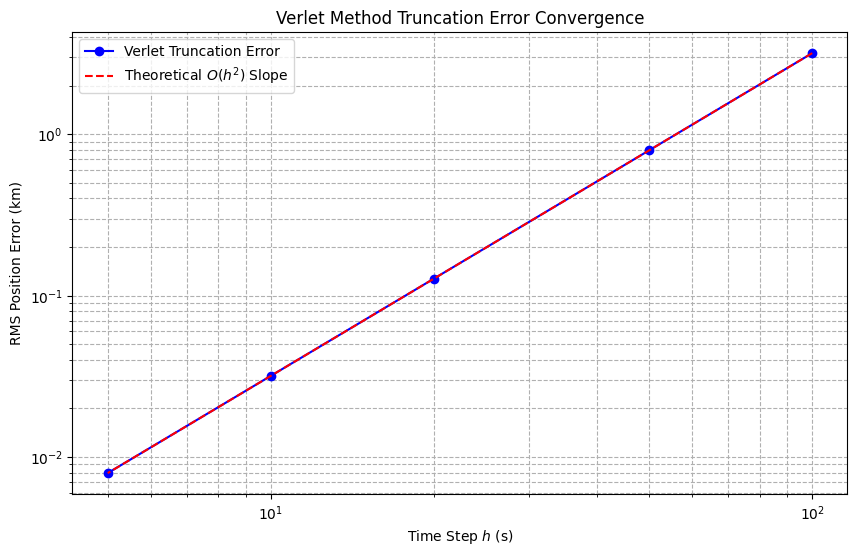

In [31]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Test multiple step sizes
step_sizes = [100, 50, 20, 10, 5]  # Time steps (seconds)
t_span = (0, orbital_period * 1)  # Simulate 1 orbital period
errors = []  # List to store RMS errors for each step size

# Loop over each step size
for h in step_sizes:
    # Generate time grid for current step size
    t_eval = np.arange(t_span[0], t_span[1], h)

    # Run Verlet integration
    _, Y_verlet = verlet_integration(system, t_span, t_eval, initial_conditions)

    # Get reference solution using high-accuracy RK45 method
    ref_sol = solve_ivp(
        system, t_span, initial_conditions,
        t_eval=t_eval, rtol=1e-12, atol=1e-12  # Tight tolerances for high accuracy
    ).y.T

    # Compute RMS truncation error (position) between Verlet and reference solution
    error = np.sqrt(np.mean(np.sum((Y_verlet[:, :3] - ref_sol[:, :3])**2, axis=1)))
    errors.append(error)  # Append RMS error for the current step size

# Plot truncation error vs step size
plt.figure(figsize=(10, 6))
# Plot the RMS error for Verlet method
plt.loglog(step_sizes, errors, 'bo-', label='Verlet Truncation Error')
# Plot the expected theoretical slope for O(h^2) convergence
plt.loglog(step_sizes, [errors[0] * (h/step_sizes[0])**2 for h in step_sizes],
           'r--', label='Theoretical $O(h^2)$ Slope')
# Add labels, title, and legend
plt.xlabel('Time Step $h$ (s)')
plt.ylabel('RMS Position Error (km)')
plt.title('Verlet Method Truncation Error Convergence')
plt.legend()  # Show the legend
plt.grid(True, which="both", ls="--")  # Display grid lines
plt.show()  # Show the plot


## Explanation of the Code for Satellite Trajectory Deviation (Perturbed vs Unperturbed)

This code compares the satellite trajectory in a perturbed system (including gravitational perturbations) to that in an unperturbed system (Keplerian gravity only). The difference in the two trajectories is plotted to show how perturbations affect the satellite's path over time. Here's a breakdown of the code:

### Key Steps:

1. **Unperturbed System (Keplerian Gravity Only):**
   - The function `unperturbed_system(t, y)` defines the motion of a satellite in orbit under the influence of only Keplerian gravity (no perturbations).
   - The acceleration of the satellite at each time step is calculated based on the gravitational force, using Newton's law of gravitation.

2. **Perturbed System:**
   - The `system` function (not fully shown) represents the perturbed motion of the satellite, which might include other forces like atmospheric drag or third-body effects.

3. **Verlet Integration:**
   - The **Verlet integration** method is used to numerically integrate both the perturbed and unperturbed systems. The `verlet_integration` function returns the positions and velocities of the satellite over time.

4. **Computing Position Deviation:**
   - The **Euclidean distance** between the positions of the satellite in the perturbed and unperturbed systems is computed at each time step to show how much the trajectories deviate due to perturbations.

5. **Plotting the Deviation:**
   - A plot is generated to show how the position deviation changes over time, with time converted to hours. The deviation gives a sense of the long-term effects of the perturbations on the satellite's orbit.

### Visual Output:
- The plot shows the **position deviation** between the perturbed and unperturbed trajectories of the satellite over time. This helps visualize how small perturbations accumulate and cause deviations from the ideal Keplerian orbit.


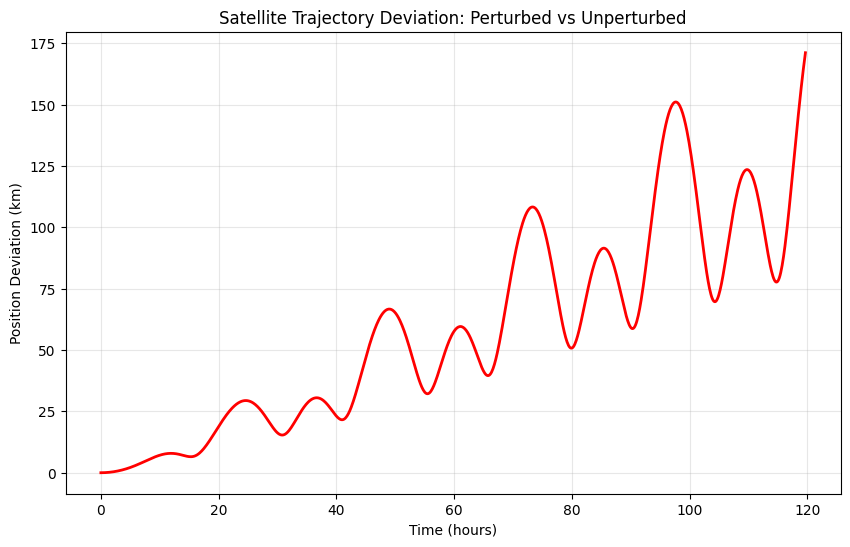

In [32]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# Function for unperturbed system (only Keplerian gravity)
def unperturbed_system(t, y):
    # Extract position and velocity components from the state vector
    y1, y2, y3, y4, y5, y6 = y
    r = np.linalg.norm(y[:3])  # Distance from the origin (magnitude of position vector)

    # Derivatives for position and velocity
    dy1_dt = y4  # dx/dt (velocity components)
    dy2_dt = y5  # dy/dt
    dy3_dt = y6  # dz/dt
    dy4_dt = -miu * y1 / r**3  # Acceleration due to gravity (Newton's law)
    dy5_dt = -miu * y2 / r**3  # Acceleration due to gravity
    dy6_dt = -miu * y3 / r**3  # Acceleration due to gravity
    return [dy1_dt, dy2_dt, dy3_dt, dy4_dt, dy5_dt, dy6_dt]

# Simulate both systems using Verlet
t_span = (0, orbital_period * 5)  # Simulate for 5 orbital periods
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time evaluation points

# Run Verlet integration for both systems (perturbed and unperturbed)
_, perturbed_sol = verlet_integration(system, t_span, t_eval, initial_conditions)
_, unperturbed_sol = verlet_integration(unperturbed_system, t_span, t_eval, initial_conditions)

# Extract positions (first 3 columns are x, y, z coordinates)
perturbed_pos = perturbed_sol[:, :3]  # Shape: (1000, 3)
unperturbed_pos = unperturbed_sol[:, :3]  # Shape: (1000, 3)

# Compute Euclidean distance between position vectors at each time step
distance = np.linalg.norm(perturbed_pos - unperturbed_pos, axis=1)

# Plot the position deviation
plt.figure(figsize=(10, 6))
plt.plot(t_eval / 3600, distance, 'r-', linewidth=2)  # Convert time to hours
plt.xlabel('Time (hours)')  # Label for x-axis
plt.ylabel('Position Deviation (km)')  # Label for y-axis
plt.title('Satellite Trajectory Deviation: Perturbed vs Unperturbed')  # Plot title
plt.grid(True, alpha=0.3)  # Display grid lines

# Show the plot
plt.show()


## Explanation of the Code for 3D Trajectory using RK4 Method

This code implements the **Runge-Kutta 4th order (RK4)** method to numerically integrate the equations of motion for a satellite in orbit and compares the solution with the true solution obtained using `solve_ivp`. It then plots the trajectory of the satellite in 3D to visualize its path over time.

### Key Steps:

1. **RK4 Method Implementation:**
   - The function `rk4_system(f, t_span, t_eval, y0)` implements the **RK4 integration method**. It takes in the system of equations `f`, the time span `t_span`, the time evaluation points `t_eval`, and initial conditions `y0`.
   - At each time step, it computes four "slopes" (k1, k2, k3, k4) based on the current state of the system, which are used to update the position and velocity of the satellite. These steps are combined with weighted coefficients to produce the final value at each time step.

2. **Simulating the Satellite System:**
   - The system's motion is modeled by a set of ordinary differential equations (ODEs) that describe the satellite's position and velocity in space. These equations are solved using the RK4 method.

3. **True Solution with `solve_ivp`:**
   - The true solution is computed using the `solve_ivp` function, which provides a high-accuracy solution to the system of ODEs. This solution is used to compare the accuracy of the RK4 method.

4. **3D Trajectory Plot:**
   - The code extracts the satellite's position (`x`, `y`, `z`) from the results of the RK4 method and the true solution.
   - A **3D plot** is created using `matplotlib` to visualize the satellite's trajectory. The starting and ending positions are highlighted with green and red points, respectively.

### Visual Output:
- The 3D plot shows the trajectory of the satellite over time. The **starting** and **ending** points of the trajectory are marked to visualize how the satellite moves along its orbital path.


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# RK4 method for solving ODEs
def rk4_system(f, t_span, t_eval, y0):
    """
    Implements the RK4 method for a system of ODEs.

    Parameters:
        f: Function returning derivatives [dx/dt, dy/dt, dz/dt, dvx/dt, dvy/dt, dvz/dt].
        t_span: Tuple (t_start, t_end) specifying the time range.
        t_eval: Array of time points where the solution is evaluated.
        y0: Initial conditions [x0, y0, z0, vx0, vy0, vz0].

    Returns:
        t_values: Time points.
        Y_values: Array of solution values for each time point.
    """
    h = t_eval[1] - t_eval[0]  # Step size
    num_steps = len(t_eval)

    Y_values = np.zeros((num_steps, len(y0)))  # Store results
    Y_values[0] = y0  # Set initial conditions

    for i in range(num_steps - 1):
        t = t_eval[i]
        Y = Y_values[i]

        # Compute the 4 slopes (k1, k2, k3, k4) using RK4
        k1 = h * np.array(f(t, Y))
        k2 = h * np.array(f(t + h/2, Y + k1/2))
        k3 = h * np.array(f(t + h/2, Y + k2/2))
        k4 = h * np.array(f(t + h, Y + k3))

        # Update the state of the system
        Y_values[i + 1] = Y + (k1 + 2*k2 + 2*k3 + k4) / 6

    return t_eval, Y_values

# Define the system's initial conditions and orbital parameters
initial_conditions = np.hstack([r0, v0])  # Initial position and velocity
orbital_period = 2 * np.pi * np.sqrt(a**3 / miu)  # Orbital period from Kepler's third law
t_span = (0, orbital_period * simulating_times)  # Time span for simulation
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time evaluation points

# Run RK4 on the system
t_values, results = rk4_system(system, t_span, t_eval, initial_conditions)

# Extract positions (x, y, z)
x_vals, y_vals, z_vals = results[:, 0], results[:, 1], results[:, 2]

# Compute true solution using solve_ivp for comparison
true_solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, rtol=1e-10, atol=1e-13)

# 3D Trajectory Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_vals, y_vals, z_vals, label="Trajectory", color='blue')  # RK4 trajectory
ax.scatter(x_vals[0], y_vals[0], z_vals[0], color='green', label="Start", s=100)  # Starting point
ax.scatter(x_vals[-1], y_vals[-1], z_vals[-1], color='red', label="End", s=100)  # Ending point

# Labels and title for the 3D plot
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_zlabel("Z Position")
ax.set_title("3D Trajectory using RK4")
ax.legend()  # Show legend
plt.show()  # Display the plot


## Explanation of the Code for RK4 Error Analysis

This code performs an **error analysis** of the **Runge-Kutta 4th order (RK4)** method by testing its performance for different step sizes. It compares the numerical solutions obtained using RK4 with a high-accuracy reference solution computed using the **RK45** method from `solve_ivp`. The errors are quantified by computing the **root mean square (RMS) position error** between the two solutions, and the convergence of the method is analyzed by plotting the error as a function of the step size.

### Key Steps:

1. **Test Parameters:**
   - A set of **step sizes** (`step_sizes = [100, 80, 60, 40]`) is defined for testing the RK4 method. These step sizes represent the time intervals between each evaluation point during the simulation.

2. **RK4 Integration:**
   - The RK4 method is applied to the system using the `rk4_system` function with different step sizes. The state of the system (position and velocity) is updated at each time step.

3. **Reference Solution:**
   - The reference solution is computed using the **RK45 method** from `solve_ivp`, which provides a highly accurate solution with much smaller integration step sizes. This solution serves as the "true" solution for comparison.

4. **Error Calculation:**
   - The **RMS position error** between the RK4 solution and the reference solution is calculated for each step size. This is done by computing the difference between the positions obtained from both solutions, squaring the differences, averaging them, and then taking the square root.

5. **Error Convergence Plot:**
   - The error is plotted as a function of the step size on a **log-log scale** to analyze the convergence rate of the RK4 method.
   - A theoretical reference line corresponding to the expected **\( O(h^4) \)** convergence rate for RK4 is also plotted for comparison. This line indicates that the error should decrease proportional to the **4th power** of the step size.

### Visual Output:
- The **log-log plot** shows the relationship between the step size and the RMS position error. A **4th-order** convergence should be observed, where the error decreases rapidly as the step size is reduced.


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Test parameters
step_sizes = [100, 80, 60, 40]  # Step sizes to test (seconds)
t_span = (0, orbital_period * simulating_times)  # Simulation time span (total time)
errors = []  # List to store errors for each step size

# Loop through each step size
for h in step_sizes:
    # Generate the time grid for the current step size
    t_eval = np.arange(t_span[0], t_span[1], h)

    # Run the RK4 method to obtain the numerical solution
    t_rk4, Y_rk4 = rk4_system(system, t_span, t_eval, initial_conditions)

    # Compute the reference solution using a more accurate solver (RK45 method)
    ref_sol = solve_ivp(
        system, t_span, initial_conditions,
        t_eval=t_eval,
        rtol=1e-12,  # High relative tolerance
        atol=1e-12   # High absolute tolerance
    ).y.T  # Transpose to match the shape

    # Compute the RMS error of the position (first three columns: x, y, z)
    error = np.sqrt(np.mean(np.sum((Y_rk4[:, :3] - ref_sol[:, :3])**2, axis=1)))
    errors.append(error)  # Store the error
    print(f"Step size = {h} s → Error = {error:.2e}")  # Print error for each step size

# Plot the error convergence on a log-log scale
plt.figure(figsize=(8, 5))
plt.loglog(step_sizes, errors, 'o-', label='RK4 Error')  # RK4 method error plot
plt.xlabel('Step Size (s)')  # x-axis label
plt.ylabel('RMS Position Error (km)')  # y-axis label
plt.title('RK4 Method Error Convergence (4th Order)')  # Plot title
plt.grid(True, which="both", ls="--")  # Enable grid for better readability

# Add the theoretical slope for RK4 (O(h^4)) for comparison
theoretical_slope = [errors[0] * (h / step_sizes[0])**4 for h in step_sizes]  # Expected O(h^4) slope
plt.loglog(step_sizes, theoretical_slope, 'r--', label='$O(h^4)$ Reference')  # Theoretical reference line
plt.legend()  # Show legend
plt.show()  # Display the plot
